In [1]:
# Required imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# Read the 3 datasets
df_calendar = pd.read_csv('./seattle/calendar.csv')
df_listings = pd.read_csv('./seattle/listings.csv')
df_reviews = pd.read_csv('./seattle/reviews.csv')

In [3]:
# Columns of interest from listings dataset
reviews = df_listings[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value']]
rooms = df_listings[['room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']]
hosts = df_listings[['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost','extra_people']]

In [4]:
# Convert 'date' of calendar dataset to datetime.
df_calendar['month'] = pd.to_datetime(df_calendar['date']).dt.month
df_calendar['year'] = pd.to_datetime(df_calendar['date']).dt.year

In [5]:
# Concatenate the columns of interest
airbnb_listings = pd.concat((reviews,rooms,hosts),axis=1)

In [6]:
# Maps 'f':0 and 't':1
airbnb_listings['host_is_superhost'] = airbnb_listings['host_is_superhost'].map({'f':0 , 't':1})

In [7]:
# Concatenate the 'id' column and renames it to listing_id
airbnb_listings = pd.concat((airbnb_listings,df_listings['id']),axis=1)
airbnb_listings.rename(index=str, columns={"id": "listing_id"}, inplace= True)

# Merge calendar and listings dataframes on 'listing_id'
airbnb_df = pd.merge(df_calendar, airbnb_listings , on= 'listing_id')
airbnb_df.drop(['date','available'], axis=1, inplace=True)

In [8]:
airbnb_df_final = airbnb_df.copy()
# Drop rows which contains missing 'price' values
airbnb_df_final.dropna(subset=['price'],inplace=True)
#Convert 'price' to float
airbnb_df_final['price'] = airbnb_df_final['price'].str.replace("[$, ]", "").astype("float")

In [9]:
extra_cols = ['host_since', 'host_is_superhost', 'extra_people']
for col in extra_cols:
    airbnb_df_final[col].fillna(airbnb_df_final[col].mode()[0],inplace=True)
    
airbnb_df_final['host_since'] = pd.to_datetime(airbnb_df_final['host_since']).dt.year

In [10]:
def get_extra_people_fee(row):
    ''' Return 1 when there is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0
    

airbnb_df_final['extra_people'] = airbnb_df_final.apply(lambda row: get_extra_people_fee(row),axis=1)

In [11]:
def fill_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - A dataframe after doing the below steps
    
    1. For each numeric variable in df, fill the column with the mean value of the column.
    2. Create dummy columns for all the categorical variables in df, drop the original columns
    '''
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # drop listing_id and year columns
    df = df.drop(columns = ['listing_id', 'year'])
    return df

In [12]:
airbnb_df_final = fill_data(airbnb_df_final)

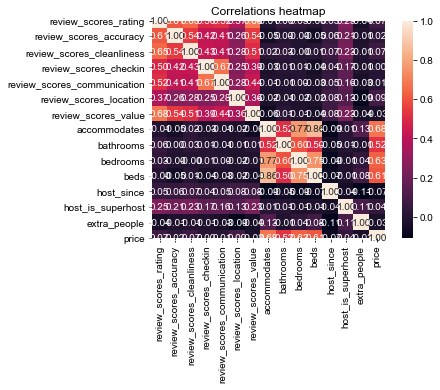

In [13]:
# Find the correlation between 'price' and other features
corr_cols = ['review_scores_rating',
             'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication',
             'review_scores_location', 'review_scores_value','accommodates', 'bathrooms', 'bedrooms', 'beds',
             'host_since', 'host_is_superhost', 'extra_people', 'price']

corrs = np.corrcoef(airbnb_df_final[corr_cols].values.T)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = corr_cols, xticklabels = corr_cols).set_title('Correlations heatmap')

sns.set(rc={'figure.figsize':(20,20)})
fig = hm.get_figure()
fig.savefig('correlations.png')

In [14]:
# Drop host_response_rate columns except 'host_response_rate_100%'
airbnb_df_final.drop(['host_response_rate_17%',
       'host_response_rate_25%', 'host_response_rate_30%',
       'host_response_rate_31%', 'host_response_rate_33%',
       'host_response_rate_38%', 'host_response_rate_40%',
       'host_response_rate_43%', 'host_response_rate_50%',
       'host_response_rate_53%', 'host_response_rate_55%',
       'host_response_rate_56%', 'host_response_rate_57%',
       'host_response_rate_58%', 'host_response_rate_60%',
       'host_response_rate_63%', 'host_response_rate_64%',
       'host_response_rate_65%', 'host_response_rate_67%',
       'host_response_rate_68%', 'host_response_rate_69%',
       'host_response_rate_70%', 'host_response_rate_71%',
       'host_response_rate_75%', 'host_response_rate_76%',
       'host_response_rate_78%', 'host_response_rate_80%',
       'host_response_rate_81%', 'host_response_rate_82%',
       'host_response_rate_83%', 'host_response_rate_86%',
       'host_response_rate_87%', 'host_response_rate_88%',
       'host_response_rate_89%', 'host_response_rate_90%',
       'host_response_rate_91%', 'host_response_rate_92%',
       'host_response_rate_93%', 'host_response_rate_94%',
       'host_response_rate_95%', 'host_response_rate_96%',
       'host_response_rate_97%', 'host_response_rate_98%',
       'host_response_rate_99%'],axis=1,inplace=True)

In [15]:
# Prepare train and test datasets
X = airbnb_df_final.drop(['price'],axis=1)
y = airbnb_df_final['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30,random_state=42)

# Instatiate the model
lm_model = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, n_jobs=-1)
# Train the model
lm_model.fit(X_train, y_train)
# Predict using the model
preds = lm_model.predict(X_test)
# Score of the model
print("R2 score: %.2f" %(r2_score(y_test, preds)))

R2 score: 0.96
